# Gradient descent optimiser

For problems where the gradient of the objective is known, we can use a simple [gradient descent]() algorithm.
Starting from any point $x[i]$, this optimiser takes the step:

$$ x[i + 1] = x[i] - \eta \cdot \nabla f(x[i]) $$

where $\eta$ is a fixed parameter called the learning rate, and $\nabla f(x[i])$ is the gradient of the objective function.

## Example 1: finding the bottom of a parabolic valley

We start off by defining a simple error function: a parabola centered at the origin:

In [1]:
import pints
import pints.toy

# Create a parabolic error function
error = pints.toy.ParabolicError()

To see what this function looks like, we'll use a contour plot.

This will get re-used later in the example, so we define a function to create it:

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the error function on a grid of points
X = np.arange(-2, 2.1, 0.1)
Y = np.arange(-1, 1.1, 0.1)
Z = np.zeros((len(Y), len(X)))
for i, x in enumerate(X):
    for j, y in enumerate(Y):
        Z[j, i] = error((x, y))
X, Y = np.meshgrid(X, Y)

# Define a function to create a contour plot
def create_contour_plot():

    # Create figure
    fig = plt.figure(figsize=(16, 8))
    ax = plt.subplot(1, 1, 1)
    plt.xlim(-2, 2)
    plt.ylim(-1, 1)

    # Plot the contours
    plt.contour(X, Y, Z, levels=20)
    
    # Show where the optimum is
    plt.plot([0], [0], 'x', color='red', label='optimum', markersize=20)

Next, we'll choose a starting point for our optimisation, and plot it on the contours of the error function:

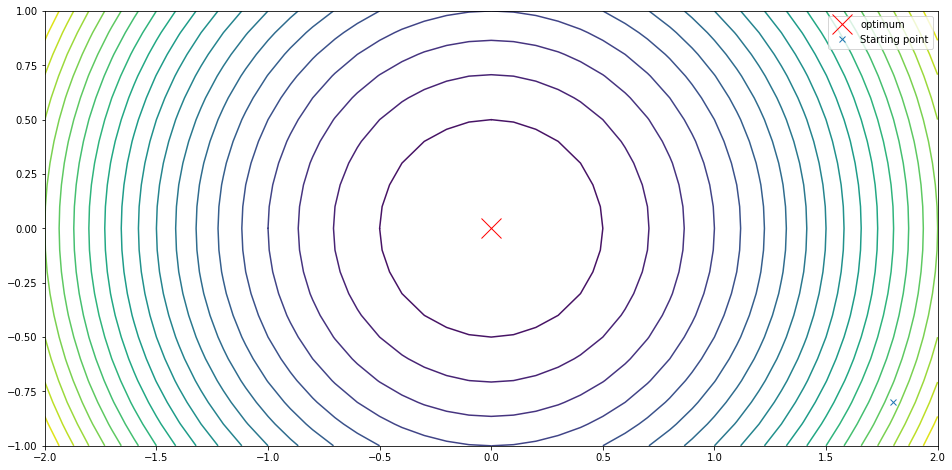

In [3]:
# Create a contour plot
create_contour_plot()

# Choose a starting point for the optimisation
x0 = [1.8, -0.8]

# Show the starting point
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Show the whole figure
plt.legend()
plt.show()

Now that the problem is all set up, we create a gradient descent optimiser and use the ask-and-tell interface to let it walk a few steps:

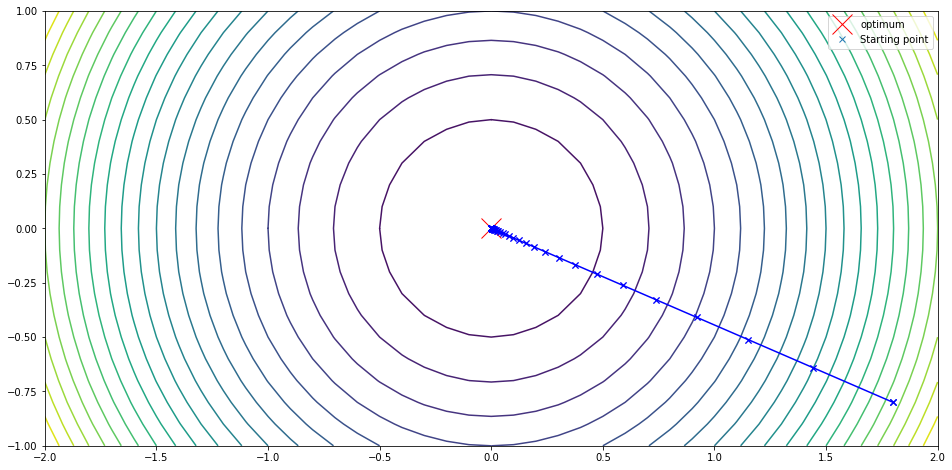

In [4]:
# Create a nice plot
create_contour_plot()
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Create an optimiser
opt = pints.GradientDescent(x0)
opt.set_learning_rate(0.1)

# Create an evaluator to evaluate the error function
# Because this method requires gradients, we must pass in the EvaluateS1 function
e = pints.SequentialEvaluator(error.evaluateS1)

# Walk a few steps, and plot the results
x1 = x0
for i in range(50):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

# Show the whole figure
plt.legend()
plt.show()

Because the gradient is very simple in this example, the optimiser can walk straight to the optimum.

At the same time, because the function gets flatter towards the optimum, the optimiser slows down and only converges very slowly to the true point.

## Example 2: Maximising a difficult LogPDF

We can also try this method on a much more difficult problem, the ["banana" twisted gaussian LogPDF](https://pints.readthedocs.io/en/latest/toy/twisted_gaussian_logpdf.html).

In the formulation included in PINTS, this is implemented as a probability density function, a LogPDF, and so we need to maximise it instead of minimising it.
An easy way to do this is to wrap a [ProbabilityBasedError](https://pints.readthedocs.io/en/latest/error_measures.html#pints.ProbabilityBasedError) around the LogPDF, turning it into an error we can minimise just like before.

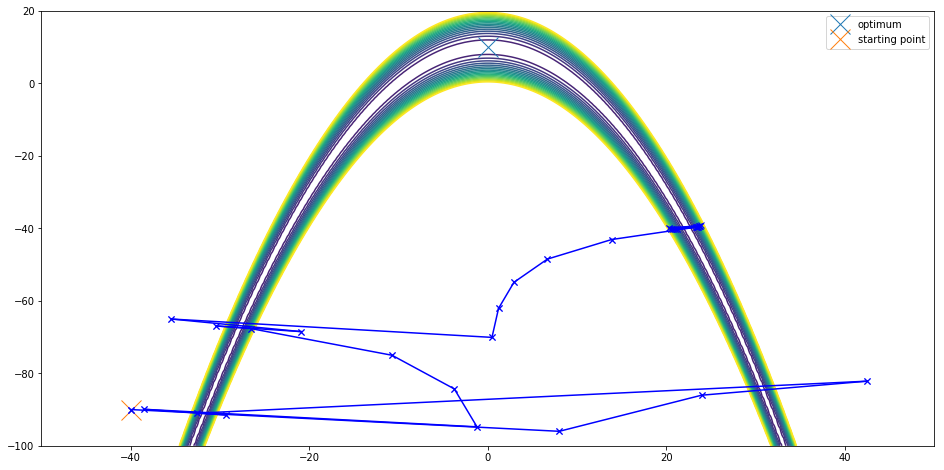

In [5]:
# Define a LogPDF (a 2-dimensional twisted gaussian)
logpdf = pints.toy.TwistedGaussianLogPDF(dimension=2)

# Wrap an error around the LogPDF
error = pints.ProbabilityBasedError(logpdf)

# Create figure
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 1, 1)
plt.xlim(-50, 50)
plt.ylim(-100, 20)

# Evaluate the error function on a grid of points
levels = np.linspace(1, 50, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-100, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]
plt.contour(X, Y, Z, levels=levels)

# Show the optimum
plt.plot(0, 10, 'x', markersize=20, label='optimum')

# Pick a starting point
x0 = [-40, -90]
plt.plot(x0[0], x0[1], 'x', markersize=20, label='starting point')

# Create an optimiser
opt = pints.GradientDescent(x0)
opt.set_learning_rate(0.1)

# Create an evaluator to evaluate the error function
# Because this method requires gradients, we must pass in the EvaluateS1 function
e = pints.SequentialEvaluator(error.evaluateS1)

# Walk a few steps, and plot the results
x1 = x0
for i in range(30):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

# Show the whole figure
plt.legend()
plt.show()

We can see the method getting into some real trouble here!

Initially, the steep gradient causes it to make large jumps and massively overshoot its target, causing the erratic behaviour in the first part of the problem.
Eventually, the method gets lucky and manages to land near a high probability area (center right).
However, at this point the gradient is still so steep that the method keeps overshooting the narrow band, and bounces from left to right.

At this point, we might try reducing the step size by lowering the "learning rate" parameter:

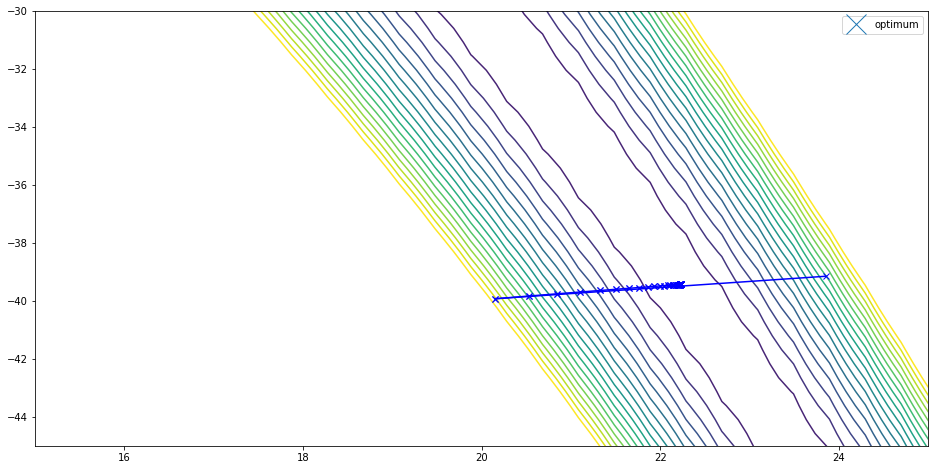

In [6]:
# Create figure
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 1, 1)
plt.xlim(15, 25)
plt.ylim(-45, -30)
plt.contour(X, Y, Z, levels=levels)
plt.plot(0, 10, 'x', markersize=20, label='optimum')

# Reduce the learning rate
opt.set_learning_rate(0.01)

# Walk some more steps, and plot the results
for i in range(250):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

# Show the whole figure
plt.legend()
plt.show()

This problem is really hard! The method is still mostly moving up and down the steep gradient, instead of flowing along "the band" towards the true optimum.

It seems some other method might be needed to tackle this type of problem.

## Example 3: A noisy time-series problem

Finally, we can try applying this method to a noisy time series problem:

In [7]:
# Load a forward model
model = pints.toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
values = model.simulate(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Perform an optimization
x0 = [0.01, 450]
opt = pints.OptimisationController(
    score,
    x0,
    method=pints.GradientDescent
)
found_parameters, found_value = opt.run()

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Minimising error measure
Using Fixed learning rate gradient descent
Running in sequential mode.
Iter. Eval. Best      Time m:s
0     1      1.93e+07   0:00.0
1     2      1.93e+07   0:00.0
2     3      1.93e+07   0:00.0
3     4      1.93e+07   0:00.0
20    21     1.93e+07   0:00.0
40    41     1.93e+07   0:00.0
60    61     1.93e+07   0:00.0
80    81     1.93e+07   0:00.0
100   101    1.93e+07   0:00.0
120   121    1.93e+07   0:00.0
140   141    1.93e+07   0:00.0
160   161    1.93e+07   0:00.0
180   181    1.93e+07   0:00.0
200   201    1.93e+07   0:00.0
201   201    1.93e+07   0:00.0
Halting: No significant change for 200 iterations.
Score at true solution: 
106499.29617521018
Found solution:          True parameters:
 1.00000000000000002e-02     1.49999999999999994e-02
 4.50000000000000000e+02     5.00000000000000000e+02


Nothing much seems to be happening. What's going on? To investigate this, we can take a quick look at the calculated gradients:

In [8]:
fx, dfx = score.evaluateS1(x0)
print(dfx)

[-8.32953136e+09 -7.48101901e+04]


This shows a very large gradient, which can lead to very large jumps in the optimisation. If these jumps don't lead to a better position, the best point found will remain the same, causing the log we saw above.

We can try to offset this effect by choosing a very small learning rate:

In [9]:
# Create optimisation controller
x0 = [0.01, 450]
opt = pints.OptimisationController(
    score,
    x0,
    method=pints.GradientDescent
)

# Set learning rate on its internal optimiser
opt.optimiser().set_learning_rate(1e-12)

# Run optimisation
found_parameters, found_value = opt.run()

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Minimising error measure
Using Fixed learning rate gradient descent
Running in sequential mode.
Iter. Eval. Best      Time m:s
0     1      1.93e+07   0:00.0
1     2      2921529    0:00.0
2     3      1935315    0:00.0
3     4      1476073    0:00.0
20    21     1281003    0:00.0
40    41     1281003    0:00.0
60    61     1281003    0:00.0
80    81     1281003    0:00.0
100   101    1281003    0:00.0
120   121    1281003    0:00.0
140   141    1281003    0:00.0
160   161    1281003    0:00.0
180   181    1281003    0:00.1
200   201    1281003    0:00.1
220   221    1281003    0:00.1
240   241    1281003    0:00.1
260   261    1281003    0:00.1
280   281    1281003    0:00.1
300   301    1281003    0:00.1
320   321    1281003    0:00.1
340   341    1281003    0:00.1
360   361    1281003    0:00.1
380   381    1281003    0:00.1
400   401    1281003    0:00.1
420   421    1281003    0:00.1
440   441    1281003    0:00.1
460   461    1281002    0:00.1
480   481    1281002    0:00.1
500  

5380  5381   1280992    0:01.7
5400  5401   1280992    0:01.8
5420  5421   1280992    0:01.8
5440  5441   1280991    0:01.8
5460  5461   1280991    0:01.8
5480  5481   1280991    0:01.8
5500  5501   1280991    0:01.8
5520  5521   1280991    0:01.8
5540  5541   1280991    0:01.8
5560  5561   1280991    0:01.8
5580  5581   1280991    0:01.8
5600  5601   1280991    0:01.8
5620  5621   1280991    0:01.8
5640  5641   1280991    0:01.8
5660  5661   1280991    0:01.8
5680  5681   1280991    0:01.8
5700  5701   1280991    0:01.9
5720  5721   1280991    0:01.9
5740  5741   1280991    0:01.9
5760  5761   1280991    0:01.9
5780  5781   1280991    0:01.9
5800  5801   1280991    0:01.9
5820  5821   1280991    0:01.9
5840  5841   1280991    0:01.9
5860  5861   1280991    0:01.9
5880  5881   1280991    0:01.9
5900  5901   1280990    0:01.9
5920  5921   1280990    0:01.9
5940  5941   1280990    0:01.9
5960  5961   1280990    0:01.9
5980  5981   1280990    0:01.9
6000  6001   1280990    0:02.0
6020  60

That seems a bit better, but now we've reached the maxmimum number of iterations without changing the second parameter much at all. We can try a slightly larger learning rate:

In [10]:
# Create optimisation controller
x0 = [0.01, 450]
opt = pints.OptimisationController(
    score,
    x0,
    method=pints.GradientDescent
)

# Set learning rate on its internal optimiser
opt.optimiser().set_learning_rate(5e-12)

# Run optimisation
found_parameters, found_value = opt.run()

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Minimising error measure
Using Fixed learning rate gradient descent
Running in sequential mode.
Iter. Eval. Best      Time m:s
0     1      1.93e+07   0:00.0
1     2      1.93e+07   0:00.0
2     3      1.93e+07   0:00.0
3     4      1.93e+07   0:00.0
20    21     1908441    0:00.0
40    41     1281374    0:00.0
60    61     1281374    0:00.0
80    81     1281374    0:00.0
100   101    1281374    0:00.0
120   121    1281374    0:00.1
140   141    1281374    0:00.1
160   161    1281374    0:00.1
180   181    1281374    0:00.1
200   201    1281374    0:00.1
220   221    1281374    0:00.1
233   233    1281374    0:00.1
Halting: No significant change for 200 iterations.
Score at true solution: 
106499.29617521018
Found solution:          True parameters:
 1.57050232705413274e-02     1.49999999999999994e-02
 4.49999998133556119e+02     5.00000000000000000e+02


This is a lot better, but we're still quite far from the true solution.

It appears that the results are very sensitive to our choice of learning rate.
A more advanced method might be needed that adapts the learning rate automatically, avoiding the need for this manual tuning.